https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
#import xgboost

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',100)

In [2]:
df_train = pd.read_csv('train.csv')

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_train.shape

(1460, 81)

In [4]:
df_test = pd.read_csv('test.csv')

df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
df_test.shape

(1459, 80)

In [6]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

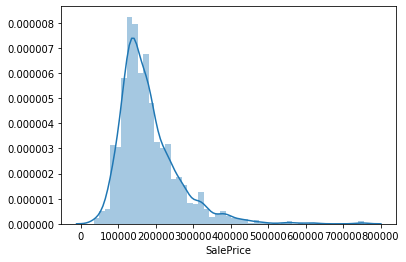

In [7]:
sns.distplot(df_train['SalePrice']);

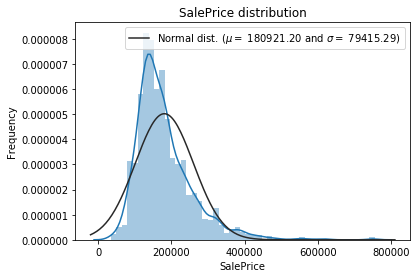

In [8]:
(mu,sigma) = norm.fit(df_train['SalePrice'])

sns.distplot(df_train['SalePrice'],fit = norm);
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu,sigma)],loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution');

In [9]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

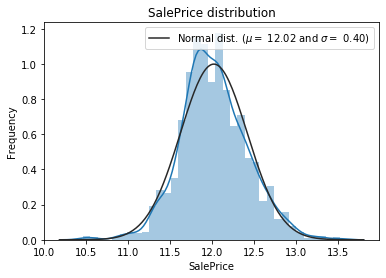

In [10]:
(mu,sigma) = norm.fit(df_train['SalePrice'])

sns.distplot(df_train['SalePrice'],fit = norm);
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu,sigma)],loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution');

In [11]:
df_train.drop('Id',axis = 1,inplace = True)
y = df_train['SalePrice']
df_train.drop('SalePrice',axis = 1,inplace = True)

Id = df_test['Id']
df_test.drop('Id',axis = 1,inplace = True)

In [12]:
dict_df = {'key_df_train':df_train,'key_df_test':df_test}

## Outliers 

## Missing Values 

In [13]:
def missing_values_table(df):
    total_nulls_by_column = df.isnull().sum().sort_values(ascending = False)
    percent_nulls_by_column = ((df.isnull().sum() / len(df)).sort_values(ascending = False)) * 100
    table = pd.concat([total_nulls_by_column,percent_nulls_by_column],axis = 1,keys = ['Total','Percent'])
    table = table[table['Total'] != 0]
    return table

In [14]:
missing_values_table_df_train = missing_values_table(dict_df['key_df_train'])

missing_values_table_df_train

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


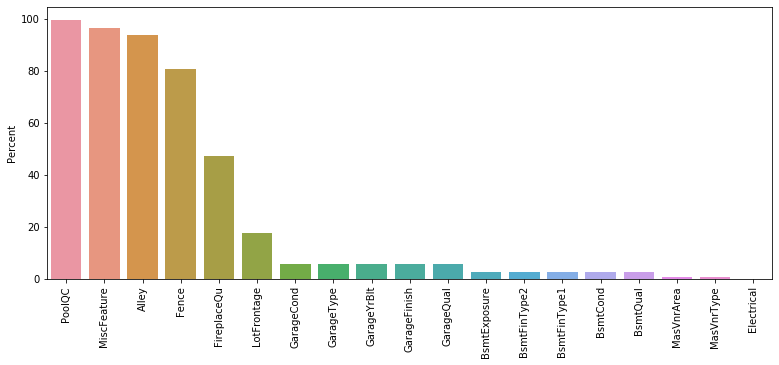

In [15]:
plt.figure(figsize = (13,5))
sns.barplot(x = missing_values_table_df_train.index,y = 'Percent',data = missing_values_table_df_train)
plt.xticks(rotation = 90)
plt.show()

In [16]:
missing_values_table_df_test = missing_values_table(dict_df['key_df_test'])

missing_values_table_df_test

,Total,Percent
PoolQC,1456,99.794380
MiscFeature,1408,96.504455
Alley,1352,92.666210
Fence,1169,80.123372
FireplaceQu,730,50.034270
LotFrontage,227,15.558602
GarageCond,78,5.346127
GarageFinish,78,5.346127
GarageYrBlt,78,5.346127
GarageQual,78,5.346127


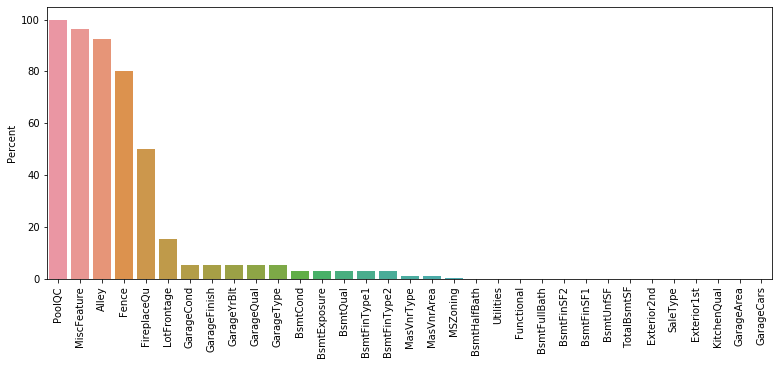

In [17]:
plt.figure(figsize = (13,5))
sns.barplot(x = missing_values_table_df_test.index,y = 'Percent',data = missing_values_table_df_test)
plt.xticks(rotation = 90)
plt.show()

In [18]:
for df in dict_df.values():
    df['PoolQC'] = df['PoolQC'].fillna('None')
    df['MiscFeature'] = df['MiscFeature'].fillna('None')
    df['Alley'] = df['Alley'].fillna('None')
    df['Fence'] = df['Fence'].fillna('None')
    df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
    df['Functional'] = df['Functional'].fillna('Typ')
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    df['MSSubClass'] = df['MSSubClass'].fillna('None')
    df['GarageType'] = df['GarageType'].fillna('None')
    df['GarageFinish'] = df['GarageFinish'].fillna('None')
    df['GarageQual'] = df['GarageQual'].fillna('None')
    df['GarageCond'] = df['GarageCond'].fillna('None')
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
    df['GarageArea'] = df['GarageArea'].fillna(0)
    df['GarageCars'] = df['GarageCars'].fillna(0)
    df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0)
    df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0)
    df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(0)
    df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)
    df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)
    df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)
    df['BsmtQual'] = df['BsmtQual'].fillna('None')
    df['BsmtCond'] = df['BsmtCond'].fillna('None')
    df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
    df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
    df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')
    df.drop('Utilities',axis = 1,inplace = True)

In [19]:
missing_values_table(dict_df['key_df_train'])

,Total,Percent


In [20]:
missing_values_table(dict_df['key_df_test'])

,Total,Percent


## Feature Engineering

In [21]:
for df in dict_df.values():
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

### Label Encoding 

In [22]:
for df in dict_df.values():
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    df['OverallCond'] = df['OverallCond'].astype(str)
    df['YrSold'] = df['YrSold'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)

In [23]:
for df in dict_df.values():
    cols = ('FireplaceQu','BsmtQual','BsmtCond','GarageQual','GarageCond','ExterQual','ExterCond','HeatingQC',
            'PoolQC','KitchenQual','BsmtFinType1','BsmtFinType2','Functional','Fence','BsmtExposure','GarageFinish',
            'LandSlope','LotShape','PavedDrive','Street','Alley','CentralAir','MSSubClass','OverallCond','YrSold','MoSold')
    for c in cols:
        lbl = LabelEncoder() 
        lbl.fit(list(df[c].values)) 
        df[c] = lbl.transform(list(df[c].values))

### Numerical Features 

In [24]:
def skewed_feats(df):
    numeric_feats = df.dtypes[df.dtypes != 'object'].index
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending = False)
    df_temp = pd.DataFrame({'Skew':skewed_feats})
    return df_temp

In [25]:
skewed_feats_df_train = skewed_feats(dict_df['key_df_train'])

skewed_feats_df_train

,Skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
LandSlope,4.808735
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186


In [26]:
skewed_feats_df_test = skewed_feats(dict_df['key_df_test'])

skewed_feats_df_test

,Skew
PoolArea,20.176117
MiscVal,20.054543
LowQualFinSF,16.150628
3SsnPorch,12.511336
LandSlope,4.963280
EnclosedPorch,4.664371
KitchenAbvGr,4.074860
BsmtFinSF2,4.038796
ScreenPorch,3.784349
BsmtHalfBath,3.779085


In [27]:
def boxcox_skewed_feats(df,df_skewed_feats):
    df_skewed_feats = df_skewed_feats[abs(df_skewed_feats) > 0.75]
    print('There are {} skewed numerical features to Box Cox transform.'.format(df_skewed_feats.shape[0]))
    skewed_feats_names = df_skewed_feats.index
    lam = 0.15
    for feat in skewed_feats_names:
        df[feat] = boxcox1p(df[feat],lam)
    print('Done!')

In [28]:
boxcox_skewed_feats(dict_df['key_df_train'],skewed_feats_df_train)

There are 59 skewed numerical features to Box Cox transform.
Done!


In [29]:
boxcox_skewed_feats(dict_df['key_df_test'],skewed_feats_df_test)

There are 59 skewed numerical features to Box Cox transform.
Done!


### Categorical Features

In [30]:
ntrain = dict_df['key_df_train'].shape[0]
ntest = dict_df['key_df_test'].shape[0]

df_all_data = pd.concat([dict_df['key_df_train'],dict_df['key_df_test']]).reset_index(drop = True)

df_all_data = pd.get_dummies(df_all_data)

df_train = df_all_data[:ntrain]
df_test = df_all_data[ntrain:]

## Modelling

In [36]:
X_train = np.array(df_train)
y_train = np.array(y)
X_test = np.array(df_test)

In [31]:
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds,shuffle = True).get_n_splits(df_train.to_numpy)
    rmse = np.sqrt(-cross_val_score(model,df_train.to_numpy,y,scoring = 'neg_mean_squared_error',cv = kf))
    return(rmse)

### Linear Regression 

In [37]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
y_pred = model.predict(X_test)

df_submission = pd.DataFrame({
    'Id': Id,
    'SalePrice': y_pred
    })

df_submission.head()

,Id,SalePrice
0,1461,11.700985
1,1462,12.024840
2,1463,12.109140
3,1464,12.165269
4,1465,12.195962


In [39]:
df_submission.to_csv('submission.csv',index = False)

### Xgboost 

In [ ]:
model = xgboost.XGBRegressor()

In [ ]:
scorer = make_scorer(rmsle,greater_is_better = False)
grid = GridSearchCV(est, param_grid, scoring=scorer)

In [ ]:
parameters = {'learning_rate':[0.01,0.1,0.5,1],'gamma':[0.5,0.1,0.001],'max_depth':[2,10,20],}

grid_search = GridSearchCV(estimator = model,param_grid = parameters,scoring = 'accuracy',cv = 5)
grid_search = grid_search.fit(X_train,y_train)